In [1]:
# Data processing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os, os.path
import random

import mne

# Model building and performance metrics
import time
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
from sklearn.metrics import r2_score, plot_roc_curve, roc_curve, auc, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
# Read .csv file
random.seed(123)
print('Loading dataset...')

eeg_data = pd.read_csv('INPUT.csv')
df_r = eeg_data.drop(labels=['Unnamed: 0','.id','.sample'], axis=1)

# Simulate data
print('Simulating data...')

def simulate(df, feature):
    sim_data = []
    sim_min = min(df[feature])
    sim_max = max(df[feature])
    
    [sim_data.append(round(random.uniform(sim_min, sim_max), 16)) for x in range(len(df))]
    
    return sim_data
    
sl_noun_pred_2_sim = simulate(df_r, 'sl_noun_pred_2')
random.shuffle(sl_noun_pred_2_sim)

subject_sim = []

for s in df_r['subject']:
    subject_sim.append(s+110)
    
# Merge with original .csv file
    
df_sim = df_r.copy()
df_sim = df_sim.drop(labels=['sl_noun_pred_2', 'subject'], axis=1)
df_sim.insert(1, 'sl_noun_pred_2', sl_noun_pred_2_sim)
df_sim.insert(2, 'subject', subject_sim)

print('Preparing data for classification...')

df_merge = pd.concat([df_r, df_sim])

df_merge['idx'] = df_merge.groupby('subject').cumcount()

# Transform to subject-level data

tmp = []
for var in ['PC1','sl_noun_pred_2']:
    df_merge['tmp_idx'] = var + '_' + df_merge.idx.astype(str)
    tmp.append(df_merge.pivot(index='subject',columns='tmp_idx',values=var))

df = pd.concat(tmp,axis=1)

# Add labels

df.insert(len(df.columns), 'label', 'conscious')
for s in df.index:
    if s > 110:
        df['label'][s] = 'unconscious'

print('Complete.')
print()

df

Loading dataset...
Simulating data...
Preparing data for classification...
Complete.



<ipython-input-2-db5bb0454208>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][s] = 'unconscious'


tmp_idx,PC1_0,PC1_1,PC1_10,PC1_100,PC1_1000,PC1_10000,PC1_10001,PC1_10002,PC1_10003,PC1_10004,...,sl_noun_pred_2_9991,sl_noun_pred_2_9992,sl_noun_pred_2_9993,sl_noun_pred_2_9994,sl_noun_pred_2_9995,sl_noun_pred_2_9996,sl_noun_pred_2_9997,sl_noun_pred_2_9998,sl_noun_pred_2_9999,label
subject,,,,,,,,,,,,,,,,,,,,,
0,-4.965919,0.735033,-13.199072,-20.163136,-10.051860,3.644624,6.524774,6.099096,12.878111,27.312137,...,0.947114,0.947114,0.947114,1.153994,1.153994,1.046544,1.046544,1.046544,0.481099,conscious
1,-12.765319,3.767211,24.837867,-16.040550,27.402840,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conscious
2,-53.866016,-52.858740,-12.918488,-28.932922,15.250234,-8.499670,-7.717359,1.323009,1.097308,-5.524753,...,1.245758,1.245758,1.144289,1.144289,1.088983,1.196434,1.245758,0.334821,0.334821,conscious
3,-50.545824,-60.900639,-72.920941,38.943199,-71.547961,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conscious
4,-3.414593,-2.730356,-34.091198,-0.202598,-25.428005,-13.826088,11.358024,62.859829,69.448321,22.045817,...,0.664166,0.664166,0.664166,-0.891039,-0.891039,-0.891039,-1.523383,-1.523383,-1.523383,conscious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,-16.062388,-10.187662,5.227092,-23.409953,-30.799265,32.480736,37.706259,34.981269,21.590126,5.540970,...,0.031914,0.066211,-1.484800,0.474093,0.200152,-1.041659,-0.825771,0.969021,-1.558003,unconscious
217,-38.346793,-45.459378,10.013780,6.816878,11.594048,-6.251401,7.967145,21.857812,37.963644,53.238093,...,1.125415,0.148658,0.356439,0.338589,-0.506789,0.316251,-0.893508,1.014211,-0.654433,unconscious
218,-17.990407,-23.589441,12.156567,22.199412,16.084157,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unconscious


In [9]:
# Train - test size, cv folds and scaling data
random.seed(123)

df = df.iloc[:,:-1].apply(pd.to_numeric)
df = df.interpolate(method='linear',axis=1)

df.insert(len(df.columns), 'label', 'conscious')
for s in df.index:
    if s > 110:
        df['label'][s] = 'unconscious'
        
        
features = df.iloc[:,:-1]
labels = df.iloc[:,-1]
labels = [1 if label == 'conscious' else 0 for label in labels]      

# Set train size, test size and numbers of folds for cv

TRAIN_SIZE = 0.8
TEST_SIZE = 0.2
CROSS_VALIDATE = 5


X_train, X_test, y_train, y_test = train_test_split(features,labels,stratify = 
                                                  labels, train_size = TRAIN_SIZE, test_size = TEST_SIZE,
                                                  random_state=42,shuffle=True)

# Scale and transform data

scaler = StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
n_classes = y_train[1]

# Basic SVM

svc = svm.SVC()
svc.fit(X_train_transformed, y_train)

# Basic RF

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_transformed, y_train)

# Define models

MODELS = [svc,
          rfc]


<ipython-input-9-c832c3834d1d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][s] = 'unconscious'


In [11]:
# Grid search for best parameters

svc_parameters = {
    'kernel':('linear', 'rbf'),
    'C':[1, 10, 100],
    'gamma':[0.1, 0.01, 0.001, 0.0001]}

rf_parameters =  {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}

svc_grid_search = GridSearchCV(estimator = svc,
                               param_grid = svc_parameters,
                               cv = CROSS_VALIDATE,
                               n_jobs = -1,
                               verbose = 1)

rf_grid_search = GridSearchCV(estimator = rfc,
                              param_grid = rf_parameters,
                              cv = CROSS_VALIDATE,
                              n_jobs = -1,
                              verbose = 1)

svc_grid_search.fit(X_train, y_train)
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.4min finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 16.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [12]:
# SVM with best parameters
KERNEL = svc_grid_search.best_params_['kernel']
C = svc_grid_search.best_params_['C']
GAMMA = svc_grid_search.best_params_['gamma']

svc = svm.SVC(kernel=KERNEL,
              C=C,
              gamma=GAMMA)
svc.fit(X_train_transformed, y_train)

# RF with best parameters
BOOTSTRAP = rf_grid_search.best_params_['bootstrap']
MAX_DEPTH = rf_grid_search.best_params_['max_depth']
MAX_FEATURES = rf_grid_search.best_params_['max_features']
MIN_SAMPLES_LEAF = rf_grid_search.best_params_['min_samples_leaf']
MIN_SAMPLES_SPLIT = rf_grid_search.best_params_['min_samples_split']
N_ESTIMATORS = rf_grid_search.best_params_['n_estimators']

rfc = RandomForestClassifier(random_state=42,
                             bootstrap = BOOTSTRAP,
                             max_depth = MAX_DEPTH,
                             max_features = MAX_FEATURES,
                             min_samples_leaf = MIN_SAMPLES_LEAF,
                             min_samples_split = MIN_SAMPLES_SPLIT,
                             n_estimators = N_ESTIMATORS)

rfc.fit(X_train_transformed, y_train)

# Define models
MODELS = [svc,
         rfc]

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)  --  10.235265016555786 s
	 VALIDATION SET PERFORMANCE
	 Accuracy: 0.9318181818181818
	 Precision: 1.0
	 Recall: 0.8636363636363636


              precision    recall  f1-score   support

           0       0.88      1.00      0.94        88
           1       1.00      0.86      0.93        88

    accuracy                           0.93       176
   macro avg       0.94      0.93      0.93       176
weighted avg       0.94      0.93      0.93       176




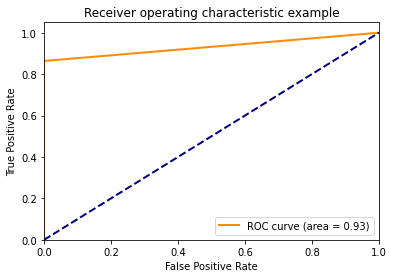

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)  --  2.717114210128784 s
	 VALIDATION SET PERFORMANCE
	 Accuracy: 1.0
	 Precision: 1.0
	 Recall: 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        88

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176




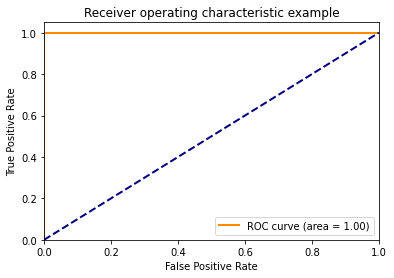

In [13]:
# Cross validate models, predict on validation set and plot metrics

# ['accuracy','f1','f1_macro','precision','recall','jaccard','roc_auc']
METRICS = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

for model in (MODELS):
    start_time = time.time()
    score = cross_validate(model, X_train_transformed, y_train,
                          scoring=METRICS, cv=CROSS_VALIDATE)
    elapsed_time = time.time() - start_time
    
    y_pred = cross_val_predict(model, X_train_transformed, y_train, n_jobs=-1, cv=CROSS_VALIDATE)
    
    print(model, ' -- ', elapsed_time, 's')
    print("\t VALIDATION SET PERFORMANCE")
    print("\t Accuracy:", metrics.accuracy_score(y_train, y_pred))
    print("\t Precision:", metrics.precision_score(y_train, y_pred))
    print("\t Recall:", metrics.recall_score(y_train, y_pred))
    print()
    print()
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_train.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    print(classification_report(y_train, y_pred))
    print()
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

	 --  2.717114210128784 s
	 TEST SET PERFORMANCE
	 Accuracy: 0.7777777777777778
	 Precision: 0.9333333333333333
	 Recall: 0.6086956521739131


              precision    recall  f1-score   support

           0       0.70      0.95      0.81        22
           1       0.93      0.61      0.74        23

    accuracy                           0.78        45
   macro avg       0.82      0.78      0.77        45
weighted avg       0.82      0.78      0.77        45


[[21  1]
 [ 9 14]]
TP: 21 
FP: 1 
FN: 9 
TN: 14



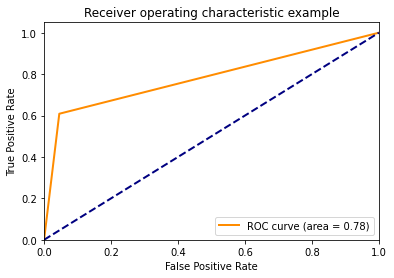

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

	 --  2.717114210128784 s
	 TEST SET PERFORMANCE
	 Accuracy: 0.9555555555555556
	 Precision: 1.0
	 Recall: 0.9130434782608695


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      0.91      0.95        23

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45


[[22 

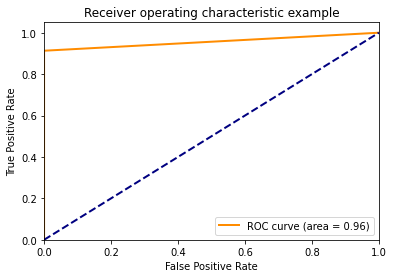

In [14]:
# Use trained models to predict on test set

for model in (MODELS):
    i = 0
    start_time = time.time()
    y_pred = cross_val_predict(model, X_test_transformed, y_test, cv=CROSS_VALIDATE)
    
    print(model)
    print()
    print("\t -- ", elapsed_time, "s")
    print("\t TEST SET PERFORMANCE")
    print("\t Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("\t Precision:", metrics.precision_score(y_test, y_pred))
    print("\t Recall:", metrics.recall_score(y_test, y_pred))
    print()
    print()
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    print(classification_report(y_test, y_pred))
    print()
    print(confusion_matrix(y_test, y_pred))
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    print("TP:", tp, "\nFP:", fp, "\nFN:", fn, "\nTN:", tn)
    print()
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    if i == 0:
        plt.savefig(str(model)[0:3] + "_plot.pdf")
    else:
        plt.savefig(str(model)[0:12] + "_plot.pdf")
    i += 1
    plt.show()
